<h1>Analisis de componentes principales (PCA) para embeddings medios</h1>

La idea inicial era crear un modelo que realizara la clasificacion de los datos mediante el embeding medio, sin embargo, es necesario efectuar un analisis de los datos, para saber si un modelo lineal puede separar los datos. Esto lo hacemos mediante PCA.

In [ ]:
## Descomenta estas lineas si se está trabajando desde Google Colab

#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


El siguiente codigo se repite a lo largo de varios notebooks, se encarga de la carga del BertTokenizer y su sistema de embeddings.

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Cargar tokenizer y modelo
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Mover modelo a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
## Función para obtener el embedding medio de un texto
def get_mean_embedding(text):
    # Tokenización y envío a GPU
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        # SOLO token embeddings, sin positional encoding
        token_embeddings = model.embeddings.word_embeddings(inputs["input_ids"])
        token_matrix = token_embeddings.squeeze(0)       # (n_tokens, d_model)
        mean_embedding = token_matrix.mean(dim=0)        # (d_model,)
    return mean_embedding.cpu().numpy()

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/techespere/dataset.csv", sep=";")
#df = pd.read_csv("../data/dataset.csv", sep=";") ## Descomentar si se trabaja en local
df["text"] = (df["title"].fillna("") + " " + df["abstract"].fillna("")).str.strip()

X = df["text"].values
y = df["group"].values

Hacemos que las clases funcionen como binarios, estableciendo un orden pre definido de las clases.

Esto convierte una clase -> neurological|hepatorenal -> 0 1 1 0

Despues se guarda como array de numpy

In [ ]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Define el orden fijo de las clases (columnas):
CLASSES = ['cardiovascular', 'neurological', 'hepatorenal', 'oncological']

# Parseo simple: split por '|'
y_lists = [s.split('|') if isinstance(s, str) and s else [] for s in y]

mlb = MultiLabelBinarizer(classes=CLASSES)
y_bin = mlb.fit_transform(y_lists)  # shape: (n_samples, 4)

# Opcional: verificar orden
print("Orden de columnas:", mlb.classes_)

Orden de columnas: ['cardiovascular' 'neurological' 'hepatorenal' 'oncological']


In [38]:
X = np.vstack([get_mean_embedding(text) for text in df["text"].values])
print("Shape de X:", X.shape)  # (num_samples, d_model=768)

Shape de X: (3565, 768)


In [39]:
X.shape, y_bin.shape

((3565, 768), (3565, 4))

<h2>PCA analisis</h2>

Haciendo uso del PCA en la libreria <i>scikit-learn</i> usamos una serie de colores principales para la muestra de los datos (4 colores, uno para cada clase principal). Selecccionamos 3 muestras aleatorias de cada una de las combinaciones de clases (15 en total) y a cada una de estas, le realizamos una reduccion de dimensionalidad mediante pca de 768 dims -> 2 dims

Al visualizar estas combinaciones, cobinamos los colores de las clases principales para diferenciar las distintas clases.

/tmp/ipython-input-3101134486.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), 3), random_state=42))


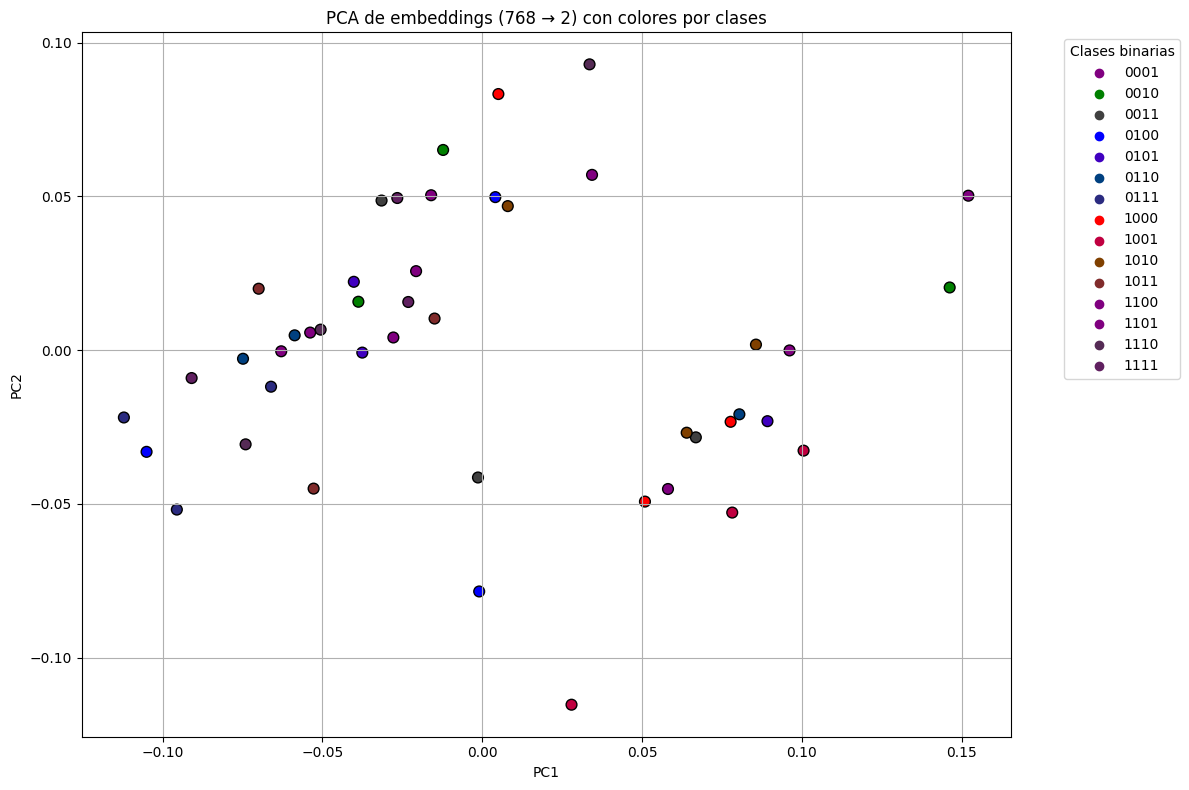

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

# Colores base para cada clase
class_colors = {
    "cardiovascular": "red",
    "neurological": "blue",
    "hepatorenal": "green",
    "oncological": "purple"
}

# Convertimos Y en tuplas
Y_tuples = [tuple(row) for row in y_bin]

# Crear dataframe auxiliar
df = pd.DataFrame({
    "embedding": list(X),
    "label_tuple": Y_tuples
})

# Seleccionar 3 muestras aleatorias por grupo
df_sampled = (
    df.groupby("label_tuple", group_keys=False)
      .apply(lambda g: g.sample(min(len(g), 3), random_state=42))
      .reset_index(drop=True)
)

# Extraer embeddings y labels seleccionados
X_sel = np.vstack(df_sampled["embedding"].values)
Y_sel = np.array(df_sampled["label_tuple"].tolist())

# PCA a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sel)

# Función para mezclar colores de varias clases
def get_mixed_color(binary_label):
    colors = []
    for i, val in enumerate(binary_label):
        if val == 1:
            cls_name = list(class_colors.keys())[i]
            colors.append(to_rgb(class_colors[cls_name]))
    if len(colors) == 0:
        return (0, 0, 0)  # negro si no hay clase
    return tuple(np.mean(colors, axis=0))

# Asignar colores
point_colors = [get_mixed_color(lbl) for lbl in Y_sel]

# Graficar
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=point_colors, s=60, edgecolors="k")

plt.title("PCA de embeddings (768 → 2) con colores por clases")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)

# ---- Leyenda personalizada ----
unique_labels = np.unique(Y_sel, axis=0)
for lbl in unique_labels:
    binary_str = "".join(map(str, lbl))
    color = get_mixed_color(lbl)
    plt.scatter([], [], c=[color], label=binary_str)

plt.legend(title="Clases binarias", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Este analisis por PCA muestra quee los diferentes embeddings medios estan mezclados, esto implica que se requiere un modelo que encuentre diferentes relaciones entre los datos para que la separacion de los mismos sea efectiva.